In [1]:
import numpy as np
from PIL import Image
from torchvision.transforms import functional as F
from pathlib import Path
from natsort import natsorted
from utils import save_colored_mask

In [25]:
output_dir = Path(r'./output')
image = Path(r'D:\datasets\yq-tech\data\image\390.png')
img = Image.open(image)

In [62]:
# 设置一下调整参数和输出路径
contrast_factor = [0.6, 1.5, 2, -0.6, -1.5, -2]
operation = 'adjust_contrast'
for factor in contrast_factor:
    deal_img = F.adjust_contrast(img, factor)
    output_path = output_dir.joinpath(f"{operation}_{factor}.png")
    deal_img.save(output_path)

In [74]:
brightness_factor = [0.6, 0.8, 1.2, 1.4, 1.6, 2]
operation = 'adjust_brightness'
for factor in brightness_factor:
    deal_img = F.adjust_brightness(img, factor)
    output_path = output_dir.joinpath(f"{operation}_{factor}.png")
    deal_img.save(output_path)

In [83]:
saturation_factor = [0.6, 1.5, 2, -0.6, -1.5, -2]
operation = 'adjust_saturation'
for factor in saturation_factor:
    deal_img = F.adjust_saturation(img, factor)
    output_path = output_dir.joinpath(f"{operation}_{factor}.png")
    deal_img.save(output_path)

In [6]:
mask = Path(r'18_mask.png')
m = Image.open(mask)

In [46]:
target_list = natsorted(list(Path(r'D:\datasets\Massachusetts_Dataset\road mask').glob('*.png')))
mask_list = natsorted(list(Path(r'D:\datasets\Massachusetts_Dataset\palette-mask').glob('*.png')))

In [68]:
al_map = [
    (0, 0, 0),  # 黑色 未识别
    (0, 128, 0),  # 林地
    (128, 0, 0),  # 种植地
    (96, 0, 0),  # 水体
    (0, 0, 255),  # 建筑物
    (128, 0, 128),  # 道路
    (191, 0, 0),  # 硬化地表
    (128, 128, 128),  # 裸地
    (128, 128, 0),  # 草地
    (105, 105, 105)  # 浅灰色 其他
]

In [21]:
from segment_anything import SamPredictor, sam_model_registry
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [1]:
checkpoint = "sam_vit_b.pth"
model_type = "vit_b"
sam = sam_model_registry[model_type](checkpoint=checkpoint)
sam.to(device='cuda')
predictor = SamPredictor(sam)
# sam = sam_model_registry["<model_type>"](checkpoint="<path/to/checkpoint>")
# predictor = SamPredictor(sam)
# predictor.set_image(<your_image>)
# masks, _, _ = predictor.predict(<input_prompts>)

In [19]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
 
 
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white',
               linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white',
               linewidth=1.25)

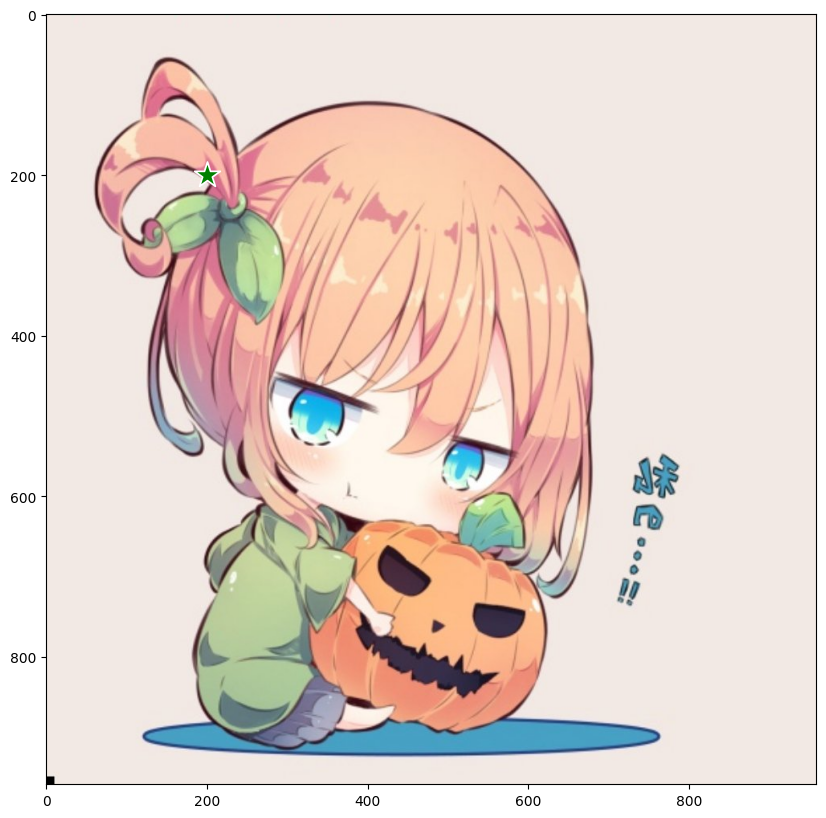

In [26]:
image = cv2.imread("test.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
predictor.set_image(image)
 
input_point = np.array([[200, 200]])
input_label = np.array([1])
 
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

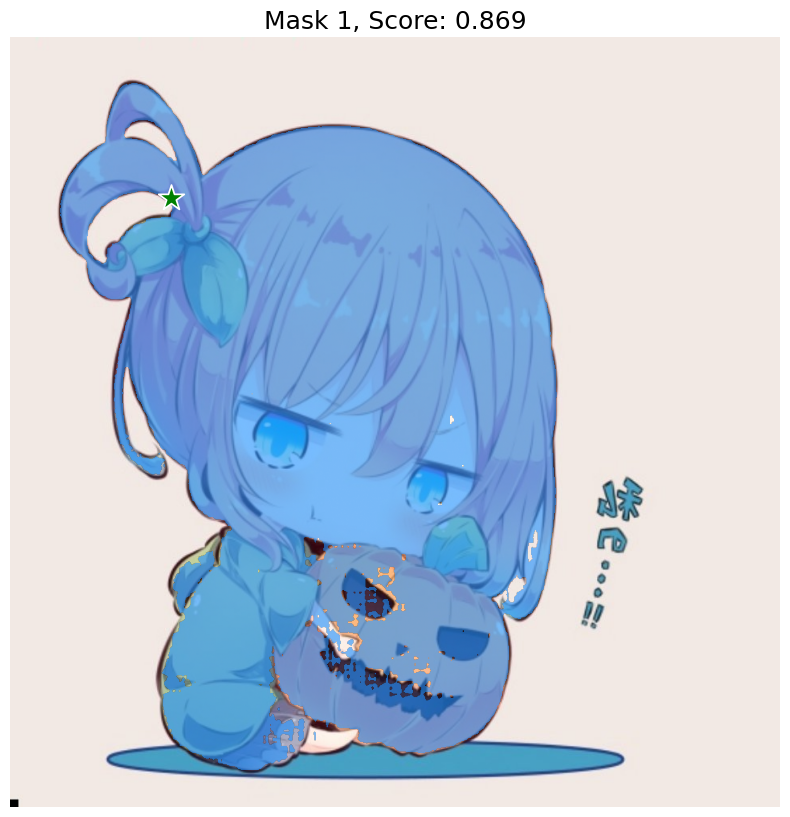

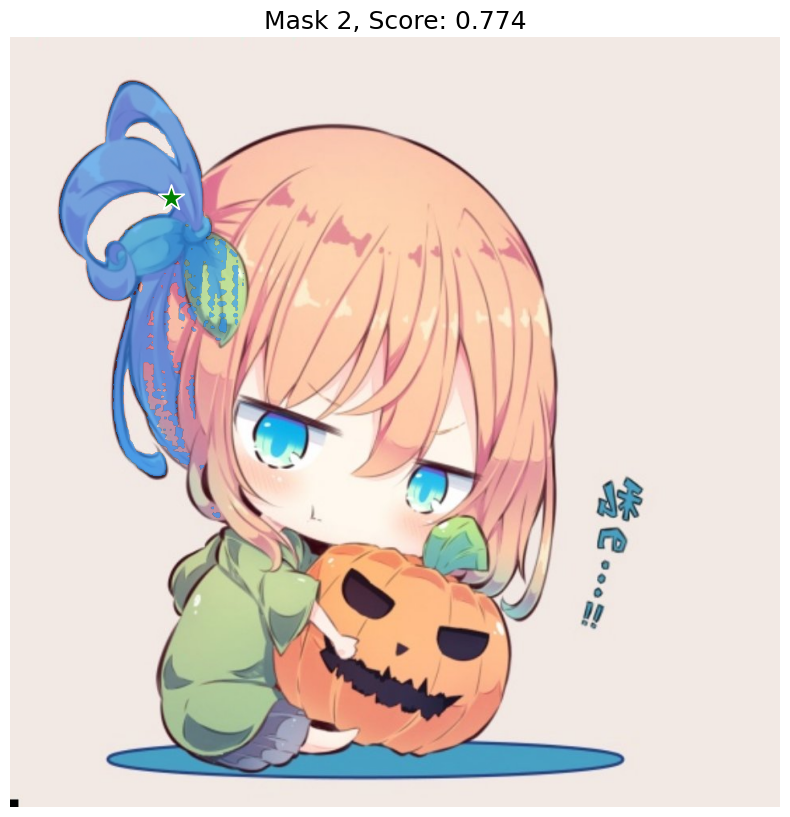

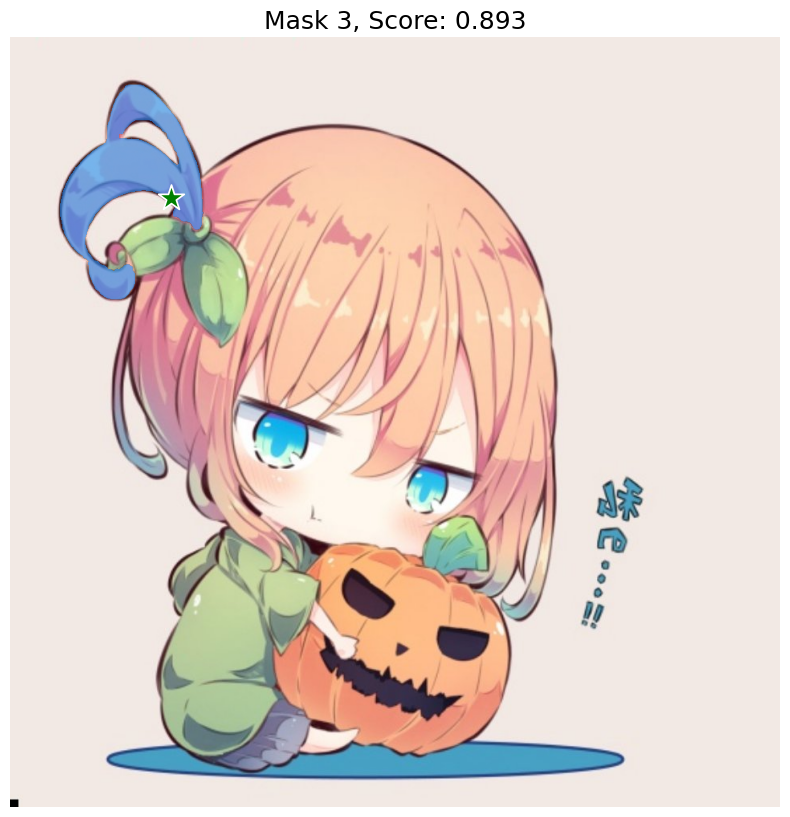

In [27]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
 
# 遍历读取每个扣出的结果
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()